In [1]:
import numpy as np
import nibabel as nib                                                     
#import itk                                                                
#import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate # Using Basic Image agumentation techniques will receive Fake Images 
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
%matplotlib inline
import seaborn as sns

import os
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [2]:
import segmentation_models as sm
import tensorflow as tf
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset
from keras.models import load_model
from tensorflow.keras import utils as np_utils
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

Segmentation Models: using `keras` framework.


(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)


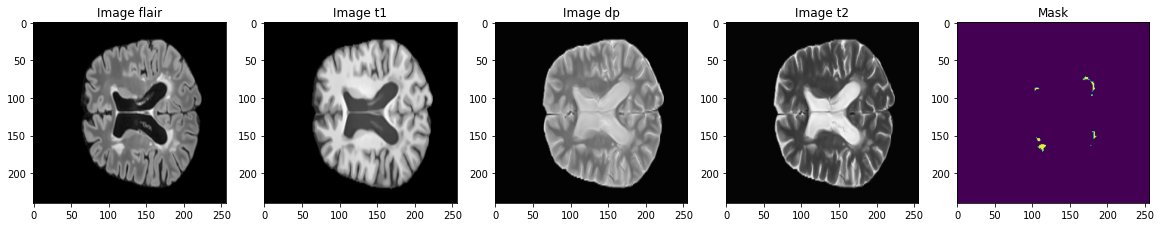

In [3]:
TRAIN_DATASET_PATH = 'D:/Projects/39111/Second_update/MSSEG2016_TrainingData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T1_preprocessed.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T2_preprocessed.nii').get_fdata()
test_image_dp=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_DP_preprocessed.nii').get_fdata()
test_image_Brain_Mask=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii').get_fdata()
    

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w =280
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_dp[:,:,test_image_dp.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image dp')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_image_Brain_Mask[:,:,test_image_Brain_Mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

print(test_image_flair.shape)
print(test_image_t1.shape)
print(test_image_t2.shape)
print(test_image_dp.shape)
print(test_image_Brain_Mask.shape)

In [4]:
SEGMENT_CLASSES = {
    0 : 'NOT_MS',
    1 : 'MS' }

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
#VOLUME_SLICES = 320 
#VOLUME_START_AT =60 # first slice of volume that we will include

VOLUME_SLICES = 180 
VOLUME_START_AT =300

In [5]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [6]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [7]:
IMG_SIZE=128

In [8]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size =1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
                
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 256))
        
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 2))
        
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_FLAIR_preprocessed.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_DP_preprocessed.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_Consensus.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
            
        # Generate masks
        y[y==0] = 0;
        
        mask = tf.one_hot(y, 2);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
    

        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


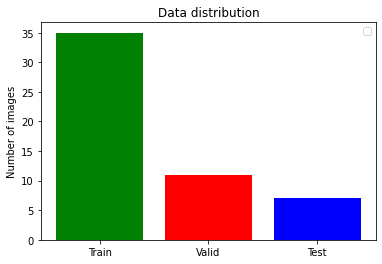

In [9]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

## UNET Model

In [10]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(256,1,2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    conv7 = concatenate([conv7,conv71], axis = 3)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(128,1,2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv81)
    conv8 = concatenate([conv8,conv81], axis = 3)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(64,1,2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv91)
    conv9 = concatenate([conv9,conv91], axis = 3)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(32,1,2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    conv = concatenate([conv,conv1], axis = 3)
    
    conv10 = Conv2D(2, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)




model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.2 ), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [11]:
from keras.callbacks import CSVLogger

'''csv_logger = CSVLogger('UNET.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]'''

"csv_logger = CSVLogger('UNET.log', separator=',', append=False)\n\n\ncallbacks = [\n#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,\n#                               patience=2, verbose=1, mode='auto'),\n      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,\n                              patience=2, min_lr=0.000001, verbose=1),\n#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',\n#                             verbose=1, save_best_only=True, save_weights_only = True)\n        csv_logger\n    ]"

In [12]:
%%time

##Model trained and saved


'''history =  model.fit(training_generator,
                     epochs=3,              
                     validation_data = valid_generator,
                     callbacks= [callbacks]
                      )  '''

Epoch 1/3
35/35 [==============================] - 1889s 54s/step - loss: 0.8497 - accuracy: 0.2101 - mean_io_u: 0.2502 - dice_coef: 0.3039 - dice_coef_MS: 0.0039 - precision: 0.2089 - sensitivity: 0.2090 - specificity: 0.2090 - val_loss: 0.8275 - val_accuracy: 0.2209 - val_mean_io_u: 0.2501 - val_dice_coef: 0.3073 - val_dice_coef_MS: 0.0019 - val_precision: 0.2208 - val_sensitivity: 0.2209 - val_specificity: 0.2209 - lr: 1.0000e-04
Epoch 2/3
35/35 [==============================] - 1899s 54s/step - loss: 0.7931 - accuracy: 0.2467 - mean_io_u: 0.2502 - dice_coef: 0.3141 - dice_coef_MS: 0.0038 - precision: 0.2466 - sensitivity: 0.2466 - specificity: 0.2466 - val_loss: 0.7813 - val_accuracy: 0.2628 - val_mean_io_u: 0.2501 - val_dice_coef: 0.3159 - val_dice_coef_MS: 0.0019 - val_precision: 0.2627 - val_sensitivity: 0.2627 - val_specificity: 0.2627 - lr: 1.0000e-04
Epoch 3/3
35/35 [==============================] - 1919s 55s/step - loss: 0.7573 - accuracy: 0.3039 - mean_io_u: 0.2502 - dice

In [13]:
#model.save("Unet.h5")

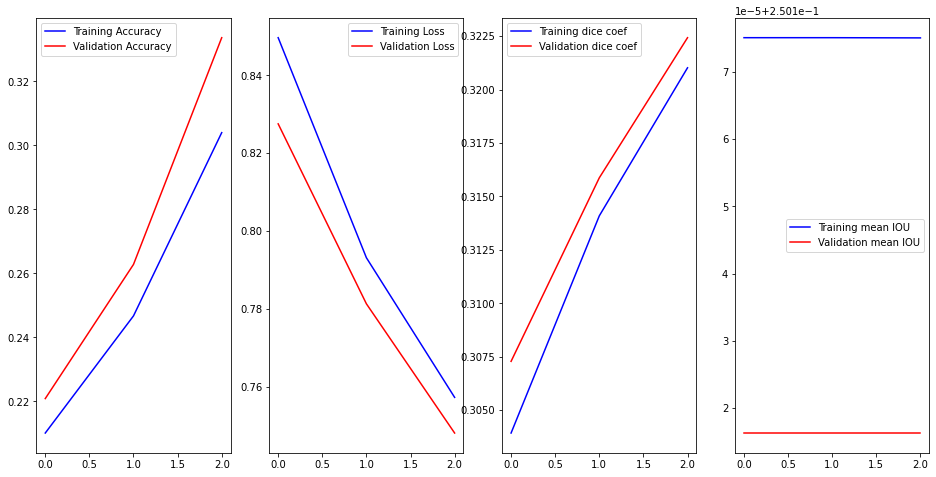

In [12]:
import pandas as pd
############ load trained model ################
model = keras.models.load_model('model_unet_final.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "dice_coef_MS": dice_coef_MS,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)

history = pd.read_csv('UNET.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [13]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.2), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
U_net_results = model.evaluate(test_generator)
print("test loss, test acc:", U_net_results)

Evaluate on test data
7/7 [==============================] - 81s 11s/step - loss: 0.6717 - accuracy: 0.8084 - mean_io_u_2: 0.2502 - dice_coef: 0.3393 - dice_coef_MS: 0.0044 - precision: 0.8079 - sensitivity: 0.8081 - specificity: 0.8081
test loss, test acc: [0.6716720461845398, 0.8084206581115723, 0.2502007782459259, 0.3393302857875824, 0.004442343953996897, 0.8079454302787781, 0.8081095814704895, 0.8081088662147522]


# Resnet

In [14]:
BACKBONE = 'resnet50'

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 2 
activation = 'softmax'

#create model
model_resnet = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True, input_shape = (128,128,2))


# compile keras model with defined optimozer, loss and metrics
model_resnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )

model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 2)  6           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 2)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   6272        ['zero_padding2d[0][0]']   

In [15]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('RESNET.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [14]:
'''%%time

history1 =  model_resnet.fit   ( training_generator,
                                 epochs=3,
                                 validation_data = valid_generator,
                                 callbacks=[callbacks]                              
                               )'''


Epoch 1/2
35/35 [==============================] - 1240s 35s/step - loss: 0.7038 - accuracy: 0.6638 - mean_io_u_2: 0.2502 - dice_coef: 0.3547 - dice_coef_MS: 0.0053 - precision: 0.6636 - sensitivity: 0.6637 - specificity: 0.6637 - val_loss: 0.6446 - val_accuracy: 0.7815 - val_mean_io_u_2: 0.2502 - val_dice_coef: 0.3463 - val_dice_coef_MS: 0.0031 - val_precision: 0.7813 - val_sensitivity: 0.7814 - val_specificity: 0.7814
Epoch 2/2
35/35 [==============================] - 1282s 37s/step - loss: 0.6711 - accuracy: 0.6952 - mean_io_u_2: 0.2502 - dice_coef: 0.3604 - dice_coef_MS: 0.0054 - precision: 0.6950 - sensitivity: 0.6951 - specificity: 0.6951 - val_loss: 0.6745 - val_accuracy: 0.7427 - val_mean_io_u_2: 0.2502 - val_dice_coef: 0.3394 - val_dice_coef_MS: 0.0039 - val_precision: 0.7424 - val_sensitivity: 0.7425 - val_specificity: 0.7425
CPU times: total: 2h 17min 20s
Wall time: 42min 4s


In [16]:
%%time

history1 =  model_resnet.fit   ( training_generator,
                                 epochs=3,
                                 validation_data = valid_generator,
                                 callbacks=[callbacks]                              
                               )


Epoch 1/3
35/35 [==============================] - 1278s 36s/step - loss: 0.8248 - accuracy: 0.5659 - mean_io_u_3: 0.2502 - dice_coef: 0.3303 - dice_coef_MS: 0.0064 - precision: 0.5657 - sensitivity: 0.5658 - specificity: 0.5658 - val_loss: 0.6811 - val_accuracy: 0.8085 - val_mean_io_u_3: 0.2501 - val_dice_coef: 0.3367 - val_dice_coef_MS: 0.0011 - val_precision: 0.8084 - val_sensitivity: 0.8085 - val_specificity: 0.8085 - lr: 1.0000e-04
Epoch 2/3
35/35 [==============================] - 1372s 39s/step - loss: 0.7830 - accuracy: 0.6123 - mean_io_u_3: 0.2502 - dice_coef: 0.3370 - dice_coef_MS: 0.0065 - precision: 0.6120 - sensitivity: 0.6122 - specificity: 0.6122 - val_loss: 0.6290 - val_accuracy: 0.9358 - val_mean_io_u_3: 0.2501 - val_dice_coef: 0.3482 - val_dice_coef_MS: 0.0012 - val_precision: 0.9357 - val_sensitivity: 0.9357 - val_specificity: 0.9357 - lr: 1.0000e-04
Epoch 3/3
35/35 [==============================] - 1286s 37s/step - loss: 0.7442 - accuracy: 0.6554 - mean_io_u_3: 0.2

In [17]:
model_resnet.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model_resnet.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 51s 7s/step - loss: 0.6007 - accuracy: 0.9352 - mean_io_u_4: 0.2502 - dice_coef: 0.3557 - dice_coef_MS: 0.0051 - precision: 0.9348 - sensitivity: 0.9350 - specificity: 0.9350
test loss, test acc: [0.6006808280944824, 0.9352206587791443, 0.2502008080482483, 0.35568767786026, 0.005101716611534357, 0.9347792863845825, 0.9349676966667175, 0.9349675178527832]


In [18]:
model_resnet.save("Resnet.h5")

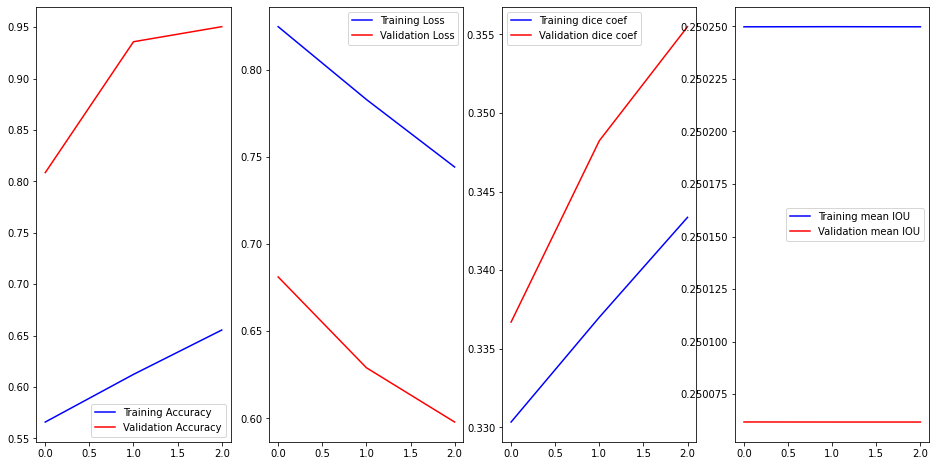

In [22]:
import pandas as pd
############ load trained model ################
model = keras.models.load_model('Resnet.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "dice_coef_MS": dice_coef_MS,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)

history = pd.read_csv('RESNET.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_3'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_3'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [23]:
model_resnet.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model_resnet.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 49s 7s/step - loss: 0.6007 - accuracy: 0.9352 - mean_io_u_9: 0.2502 - dice_coef: 0.3557 - dice_coef_MS: 0.0051 - precision: 0.9348 - sensitivity: 0.9350 - specificity: 0.9350
test loss, test acc: [0.6006807684898376, 0.9352206587791443, 0.2502008080482483, 0.35568767786026, 0.005101716611534357, 0.9347793459892273, 0.9349676966667175, 0.9349674582481384]


In [24]:
model_resnet = keras.models.load_model('model_resnet_1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_MS": dice_coef_MS                                                  
                                                  }, compile=False)

In [25]:
model_resnet.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model_resnet.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 51s 7s/step - loss: 0.7228 - accuracy: 0.5764 - mean_io_u_11: 0.2502 - dice_coef: 0.3298 - dice_coef_MS: 0.0050 - precision: 0.5762 - sensitivity: 0.5763 - specificity: 0.5763
test loss, test acc: [0.7228478193283081, 0.576431930065155, 0.2502008378505707, 0.3298403322696686, 0.00499362638220191, 0.5761653184890747, 0.5762768983840942, 0.5762767791748047]


In [26]:
resnet_results[1]

0.576431930065155

KeyError: 'mean_io_u_2'

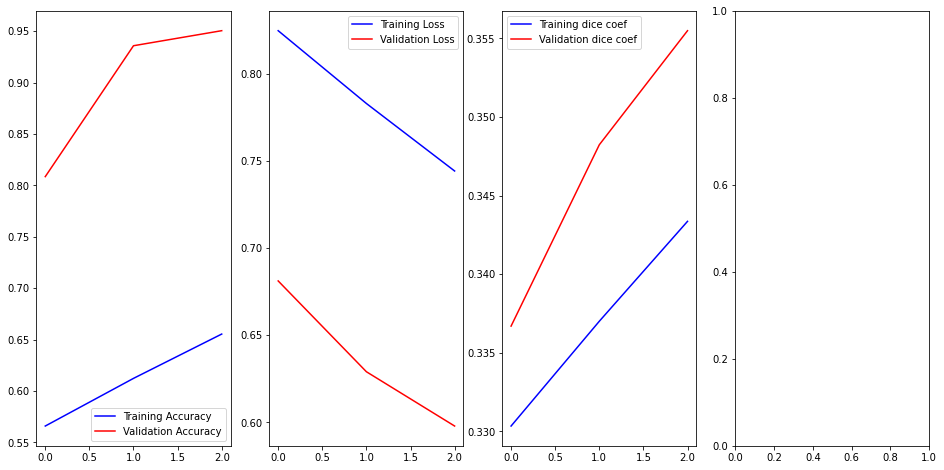

In [27]:
hist1=history1.history

acc=hist1['accuracy']
val_acc=hist1['val_accuracy']

epoch=range(len(acc))

loss=hist1['loss']
val_loss=hist1['val_loss']

train_dice=hist1['dice_coef']
val_dice=hist1['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist1['mean_io_u_2'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist1['val_mean_io_u_2'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Inceptionv3_net

In [30]:
def inceptionv3_unet():
    
    BACKBONE = 'inceptionv3'
    
    preprocess_input = sm.get_preprocessing(BACKBONE)
    
    n_classes = 2
    
    activation = 'softmax'
    
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    
    return model

model_inceptionv3 = inceptionv3_unet()

model_inceptionv3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )

#model_inceptionv3.summary()

In [32]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('Inceptionv3.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [33]:
%%time
history2 =  model_inceptionv3.fit (  training_generator,
                                    epochs=3,
                                    validation_data = valid_generator,
                                    callbacks=[callbacks]        )

Epoch 1/3
35/35 [==============================] - 1007s 29s/step - loss: 0.9011 - accuracy: 0.3173 - mean_io_u_13: 0.2502 - dice_coef: 0.3148 - dice_coef_MS: 0.0049 - precision: 0.3171 - sensitivity: 0.3171 - specificity: 0.3171 - val_loss: 0.6977 - val_accuracy: 0.3293 - val_mean_io_u_13: 0.2501 - val_dice_coef: 0.3326 - val_dice_coef_MS: 0.0010 - val_precision: 0.3292 - val_sensitivity: 0.3292 - val_specificity: 0.3292 - lr: 1.0000e-04
Epoch 2/3
35/35 [==============================] - 1068s 31s/step - loss: 0.8622 - accuracy: 0.3507 - mean_io_u_13: 0.2502 - dice_coef: 0.3213 - dice_coef_MS: 0.0049 - precision: 0.3505 - sensitivity: 0.3505 - specificity: 0.3505 - val_loss: 0.7009 - val_accuracy: 0.3618 - val_mean_io_u_13: 0.2501 - val_dice_coef: 0.3320 - val_dice_coef_MS: 0.0011 - val_precision: 0.3617 - val_sensitivity: 0.3617 - val_specificity: 0.3617 - lr: 1.0000e-04
Epoch 3/3
35/35 [==============================] - 1077s 31s/step - loss: 0.8260 - accuracy: 0.3859 - mean_io_u_13

In [34]:
model_inceptionv3.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model_inceptionv3.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 44s 6s/step - loss: 0.6974 - accuracy: 0.4794 - mean_io_u_14: 0.2502 - dice_coef: 0.3338 - dice_coef_MS: 0.0048 - precision: 0.4791 - sensitivity: 0.4792 - specificity: 0.4792
test loss, test acc: [0.6974387764930725, 0.4794033467769623, 0.2502008080482483, 0.333791047334671, 0.004804171156138182, 0.4791189134120941, 0.47921520471572876, 0.4792146682739258]


In [35]:
model_inceptionv3.save("inceptionv3.h5")

In [43]:
import pandas as pd
############ load trained model ################
model1 = keras.models.load_model('inceptionv3.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "dice_coef_MS": dice_coef_MS,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)


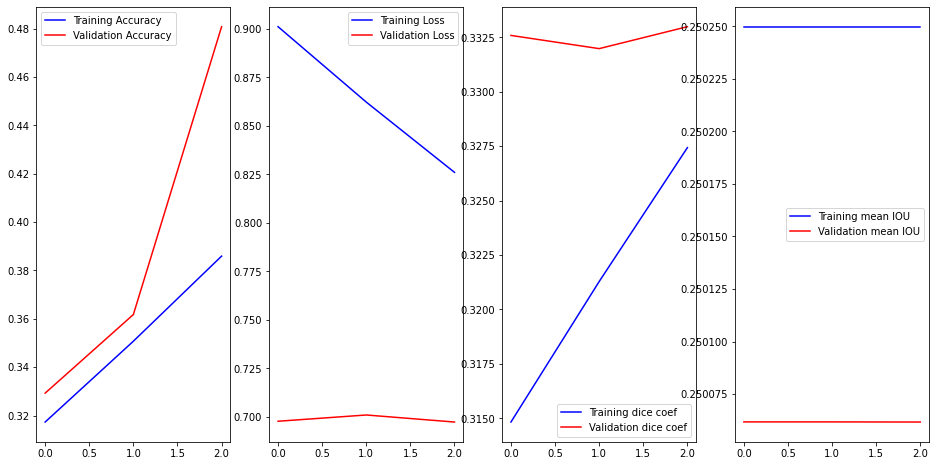

In [46]:
history = pd.read_csv('inceptionv3.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_13'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_13'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [47]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model1.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 45s 6s/step - loss: 0.6974 - accuracy: 0.4794 - mean_io_u_25: 0.2502 - dice_coef: 0.3338 - dice_coef_MS: 0.0048 - precision: 0.4791 - sensitivity: 0.4792 - specificity: 0.4792
test loss, test acc: [0.6974387764930725, 0.4794033467769623, 0.2502008080482483, 0.333791047334671, 0.004804170690476894, 0.4791189134120941, 0.47921520471572876, 0.479214608669281]


# Dual Vnet

In [58]:
def dualvnet_architecture():

#cycle0
    inputs = Input(shape=(128, 128, 2), name='input')
    convolution1 = Conv2D(
            32, 3, padding='same', activation='relu')(inputs)
    normalization1 = BatchNormalization()(convolution1)

    convolution2 = Conv2D(
            32, 3, padding='same', activation='relu')(normalization1 )
    normalization2 = BatchNormalization()(convolution2 )

    pool = MaxPooling2D()(normalization2)

#cycle1

    convolution11 = Conv2D(
            64, 3, padding='same', activation='relu')(pool)
    normalization11 = BatchNormalization()(convolution11)

    convolution12 = Conv2D(
           64, 3, padding='same', activation='relu')(normalization11)
    normalization12 = BatchNormalization()(convolution12)

    pool1 = MaxPooling2D()(normalization12)


#cycle2
    convolution21 = Conv2D(
            128, 3, padding='same', activation='relu')(pool1)
    normalization21 = BatchNormalization()(convolution21)

    convolution22 = Conv2D(
            128, 3, padding='same', activation='relu')(normalization21)
    normalization22 = BatchNormalization()(convolution22 )

    pool2 = MaxPooling2D()(normalization22)

    dropout_1 = Dropout(0.2)(pool2)

#cycle3

    convolution31 = Conv2D(256, 3, padding='same', activation='relu',
                                  )(dropout_1)
    normalization31 = BatchNormalization()(convolution31 )

    convolution32 = Conv2D(256, 3, padding='same',
                                  activation='relu')(normalization31)
    normalization32 = BatchNormalization()(convolution32)

    pool3 = MaxPooling2D()(normalization32)

#cycle4
    convolution41 = Conv2D(512, 3, padding='same', activation='relu')(pool3)
    
    normalization41 = BatchNormalization()(convolution41)

    convolution42 = Conv2D(512, 3, padding='same',
                                  activation='relu')(normalization41)
    normalization42 = BatchNormalization()(convolution42)

    pool4 = MaxPooling2D()(normalization42)

#cycle5
    convolution51 = Conv2D(
            1024, 3, padding='same', activation='relu')(pool4)

# Decoder Cycle 1

    upscaling_1 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(convolution51)

    merged1 = Add()(
            [normalization41 , normalization42, upscaling_1])

    dconvolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged1)

    upscaling_2 = Conv2DTranspose(256, 3, strides=(
           2, 2), padding='same', activation='relu')(dconvolution1 )

    merged2 = Add()(
            [normalization31 , normalization32, upscaling_2])

    dconvolution21 = Conv2D(
           256, 3, padding='same', activation='relu')(merged2)

    dropout_2 = Dropout(0.2)(dconvolution21)


    upscaling_3 = Conv2DTranspose(128, 3, strides=(
            2, 2), padding='same', activation='relu')(dropout_2)


    merged3 = Add()(
           [normalization21, normalization22, upscaling_3])

    dconvolution31 = Conv2D(
           128, 3, padding='same', activation='relu')(merged3)

    upscaling_4 = Conv2DTranspose(64, 3, strides=(
          2, 2), padding='same', activation='relu')(dconvolution31)

    merged4 = Add()(
           [normalization11, normalization12, upscaling_4])

    dconvolution41 = Conv2D(
           64, 3, padding='same', activation='relu')(merged4)

    upscaling_5 = Conv2DTranspose(32, 3, strides=(
           2, 2), padding='same', activation='relu')(dconvolution41 )

    merged5 = Add()(
           [normalization1,normalization2, upscaling_5])

    dconvolution51 = Conv2D(
            32, 3, padding='same', activation='relu')(merged5)

#encoder cycle2
#cycle6
    convolution61 = Conv2D(32, 3, padding='same', activation='relu')(dconvolution51)
    normalization61 = BatchNormalization()(convolution61)

    convolution62 = Conv2D(32, 3, padding='same',
                                  activation='relu')(normalization61)
    normalization62 = BatchNormalization()(convolution62)
    pool6 = MaxPooling2D()(normalization62)

#cycle7
    convolution71 = Conv2D(64, 3, padding='same',
                                  activation='relu')(pool6)
    normalization71 = BatchNormalization()(convolution71)
    convolution72 = Conv2D(64, 3, padding='same',
                                  activation='relu')(normalization71)
    normalization72 = BatchNormalization()(convolution72)
    pool7 = MaxPooling2D()(normalization72)

#cycle8
    convolution81 = Conv2D(128, 3, padding='same',
                                  activation='relu')(pool7)
    normalization81 = BatchNormalization()(convolution81)
    convolution82 = Conv2D(128, 3, padding='same',
                                  activation='relu')(normalization81 )
    normalization82 = BatchNormalization()(convolution82)
    pool8 = MaxPooling2D()(normalization82)

    edropout_2 = Dropout(0.2)(pool8)

#cycle9
    convolution91 = Conv2D(
            256, 3, padding='same', activation='relu')(edropout_2)
    normalization91 = BatchNormalization()(convolution91)
    convolution92 = Conv2D(256, 3, padding='same',
                                  activation='relu')(normalization91)
    normalization92 = BatchNormalization()(convolution92 )
    pool9 = MaxPooling2D()(normalization92 )
#cycle10
    convolution101 = Conv2D(512, 3, padding='same',
                                   activation='relu')(pool9)
    normalization101 = BatchNormalization()(convolution101)
    convolution102 = Conv2D(
            512, 3, padding='same', activation='relu')(normalization101)
    normalization102 = BatchNormalization()(convolution102)
    pool10 = MaxPooling2D()(normalization102)
#cycle11
    convolution111 = Conv2D(1024, 3, padding='same',
                                   activation='relu')(pool10)
    
#decode2
    upscaling_6 = Conv2DTranspose(512, 3, strides=(
           2, 2), padding='same', activation='relu')(convolution111)
    merged6 = Add()(
           [normalization101, normalization102, upscaling_6])
    dconvolution61 = Conv2D(
           512, 3, padding='same', activation='relu')(merged6)
    upscaling_7 = Conv2DTranspose(256, 3, strides=(
            2, 2), padding='same', activation='relu')(dconvolution61)
    merged7 = Add()(
            [normalization91, normalization92, upscaling_7])
    dconvolution71 = Conv2D(
            256, 3, padding='same', activation='relu')(merged7)
    ddropout_2 = Dropout(
            0.2)(dconvolution71)
    upscaling_8 = Conv2DTranspose(128, 3, strides=(
          2, 2), padding='same', activation='relu')(ddropout_2)
    merged8 = Add()(
           [normalization81 , normalization82, upscaling_8])
    dconvolution81 = Conv2D(
          128, 3, padding='same', activation='relu')(merged8)
    upscaling_9 = Conv2DTranspose(64, 3, strides=(
            2, 2), padding='same', activation='relu')(dconvolution81)
    merged9 = Add()(
           [normalization71, normalization72, upscaling_9])
    dconvolution91 = Conv2D(
           64, 3, padding='same', activation='relu')(merged9)
    upscaling_10 = Conv2DTranspose(32, 3, strides=(
            2, 2), padding='same', activation='relu')(dconvolution91)
    merged10 = Add()(
            [normalization61,normalization62, upscaling_10])
    dconvolution101 = Conv2D(
           32, 3, padding='same', activation='relu')(merged10)
    pre_output = Conv2D(32, 1, padding='same', activation='relu')(
           dconvolution101)

    output = Conv2D(2, 1, padding='same', activation='softmax',
                    name='output')(pre_output)

    model = Model(inputs=inputs, outputs=output)

    return model



model_dualvnet = dualvnet_architecture()


model_dualvnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )


In [59]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('Dualvnet.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [60]:
%%time

history3 =  model_dualvnet.fit( training_generator,
                                epochs=3,                 
                                validation_data = valid_generator,
                                callbacks=[callbacks] )
 

Epoch 1/3
35/35 [==============================] - 2039s 57s/step - loss: 0.1583 - accuracy: 0.9214 - mean_io_u_28: 0.4920 - dice_coef: 0.4762 - dice_coef_MS: 0.0094 - precision: 0.9211 - sensitivity: 0.9214 - specificity: 0.9214 - val_loss: 0.0133 - val_accuracy: 0.9998 - val_mean_io_u_28: 0.6587 - val_dice_coef: 0.4984 - val_dice_coef_MS: 3.9811e-09 - val_precision: 0.9997 - val_sensitivity: 0.9998 - val_specificity: 0.9998 - lr: 0.0010
Epoch 2/3
35/35 [==============================] - 1946s 56s/step - loss: 0.0158 - accuracy: 0.9987 - mean_io_u_28: 0.3099 - dice_coef: 0.5009 - dice_coef_MS: 0.0202 - precision: 0.9984 - sensitivity: 0.9987 - specificity: 0.9987 - val_loss: 0.0326 - val_accuracy: 0.9998 - val_mean_io_u_28: 0.2665 - val_dice_coef: 0.4929 - val_dice_coef_MS: 2.5066e-04 - val_precision: 0.9997 - val_sensitivity: 0.9998 - val_specificity: 0.9998 - lr: 0.0010
Epoch 3/3
35/35 [==============================] - 1960s 56s/step - loss: 0.0077 - accuracy: 0.9987 - mean_io_u_28

In [61]:
model_dualvnet.save("Dualvnet.h5")

In [63]:
import pandas as pd
############ load trained model ################
model1 = keras.models.load_model('Dualvnet.h5', custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "dice_coef_MS": dice_coef_MS,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity                                                                                                     
                                                  }, compile=False)


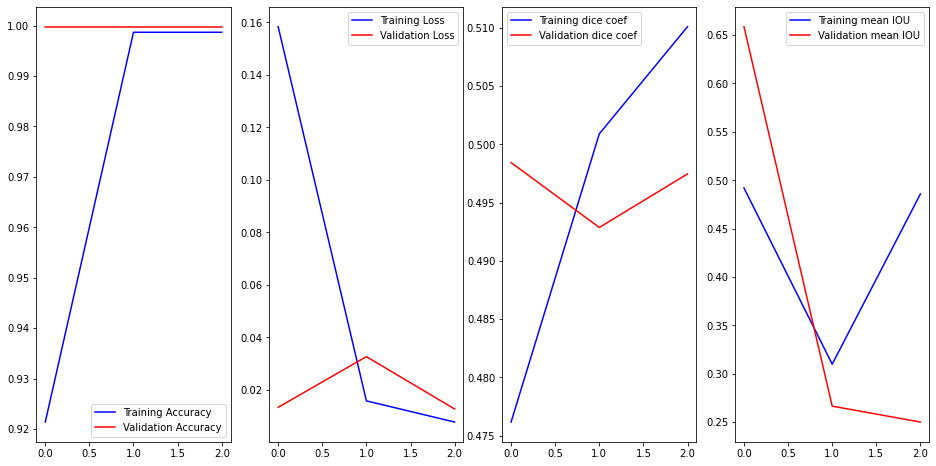

In [64]:
history = pd.read_csv('Dualvnet.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_28'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_28'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [65]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model1.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 105s 14s/step - loss: 0.0186 - accuracy: 0.9989 - mean_io_u_31: 0.2502 - dice_coef: 0.4975 - dice_coef_MS: 0.0039 - precision: 0.9987 - sensitivity: 0.9989 - specificity: 0.9989
test loss, test acc: [0.018554428592324257, 0.998945951461792, 0.2502008378505707, 0.49753379821777344, 0.0038948715664446354, 0.9987446665763855, 0.9989452958106995, 0.9989452958106995]


In [62]:
model_dualvnet.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet_results = model_dualvnet.evaluate(test_generator)
print("test loss, test acc:", resnet_results)

Evaluate on test data
7/7 [==============================] - 97s 14s/step - loss: 0.0186 - accuracy: 0.9989 - mean_io_u_29: 0.2502 - dice_coef: 0.4975 - dice_coef_MS: 0.0039 - precision: 0.9987 - sensitivity: 0.9989 - specificity: 0.9989
test loss, test acc: [0.018554430454969406, 0.998945951461792, 0.2502008080482483, 0.4975338280200958, 0.0038948715664446354, 0.9987446069717407, 0.9989452958106995, 0.9989452958106995]


11/11 [==============================] - 26s 2s/step


<Figure size 1296x2160 with 0 Axes>

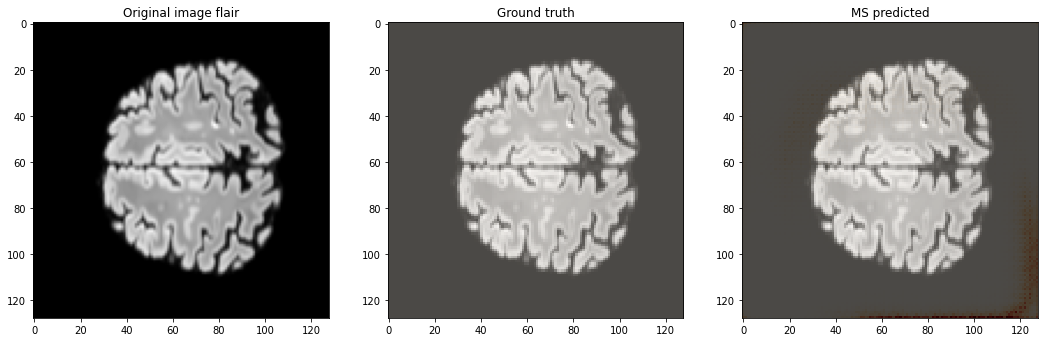

11/11 [==============================] - 25s 2s/step


<Figure size 1296x2160 with 0 Axes>

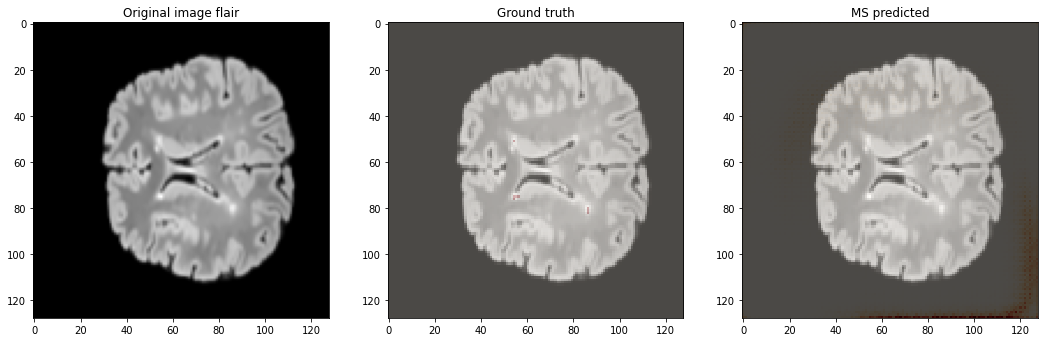

11/11 [==============================] - 26s 2s/step


<Figure size 1296x2160 with 0 Axes>

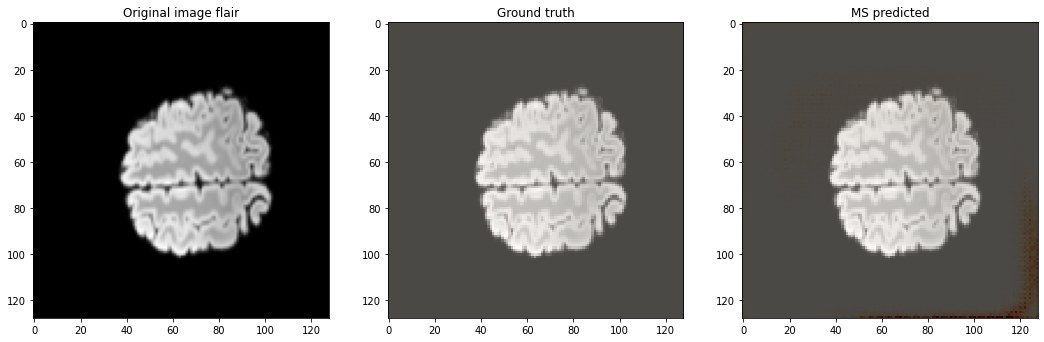

11/11 [==============================] - 30s 3s/step


<Figure size 1296x2160 with 0 Axes>

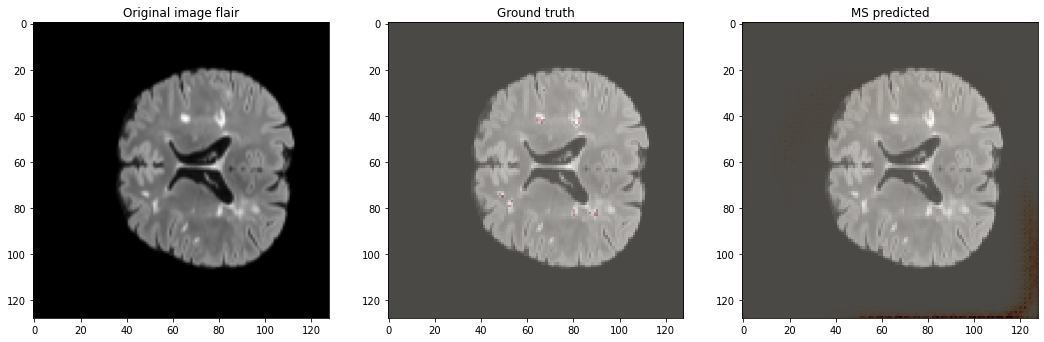

11/11 [==============================] - 34s 3s/step


<Figure size 1296x2160 with 0 Axes>

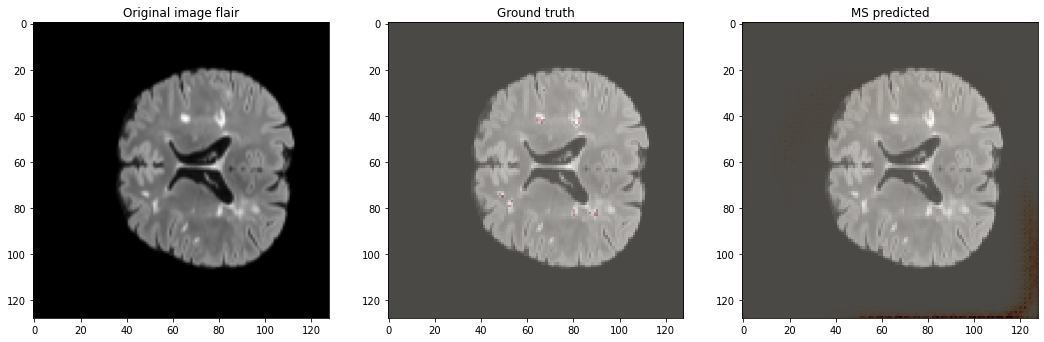

11/11 [==============================] - 27s 2s/step


<Figure size 1296x2160 with 0 Axes>

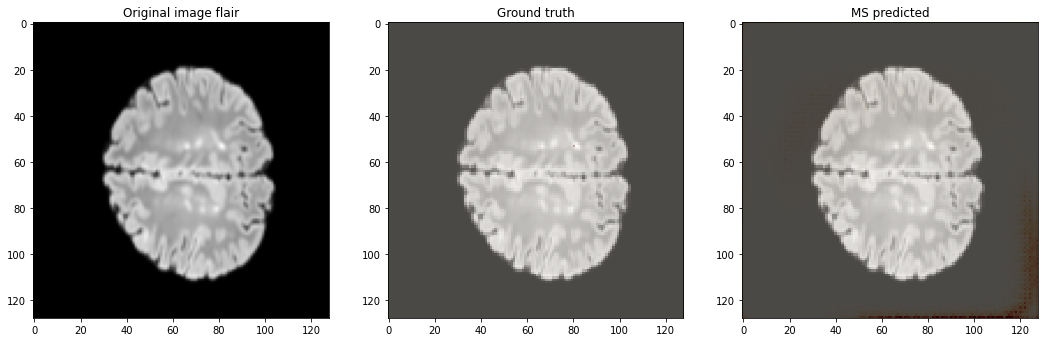

11/11 [==============================] - 29s 3s/step


<Figure size 1296x2160 with 0 Axes>

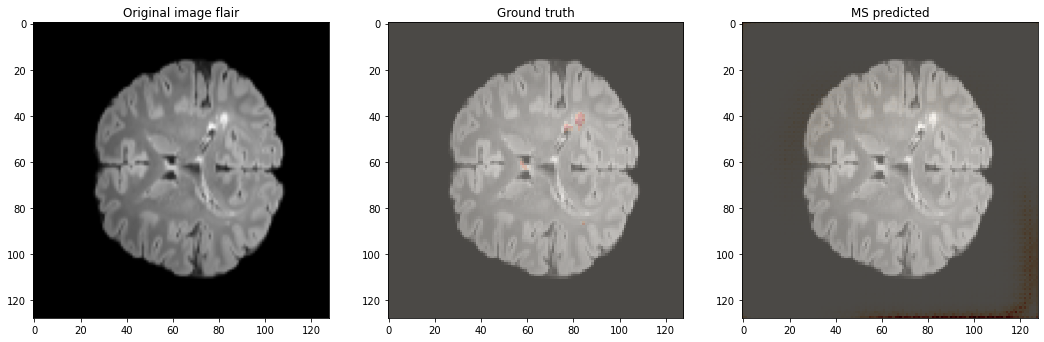

11/11 [==============================] - 27s 2s/step


<Figure size 1296x2160 with 0 Axes>

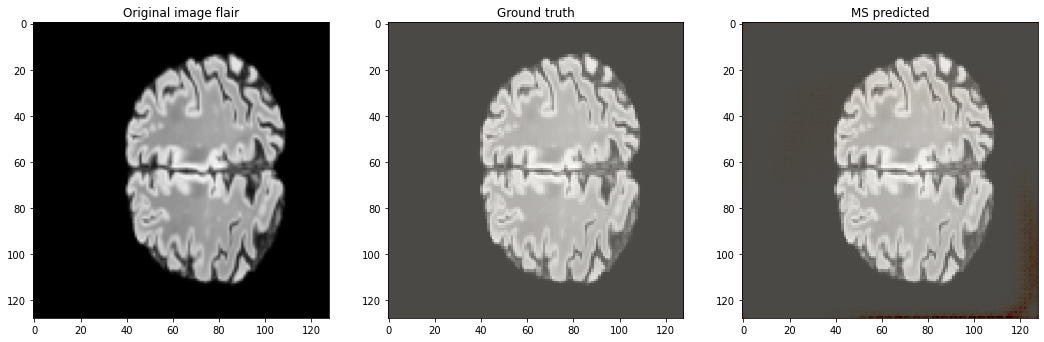

11/11 [==============================] - 27s 2s/step


<Figure size 1296x2160 with 0 Axes>

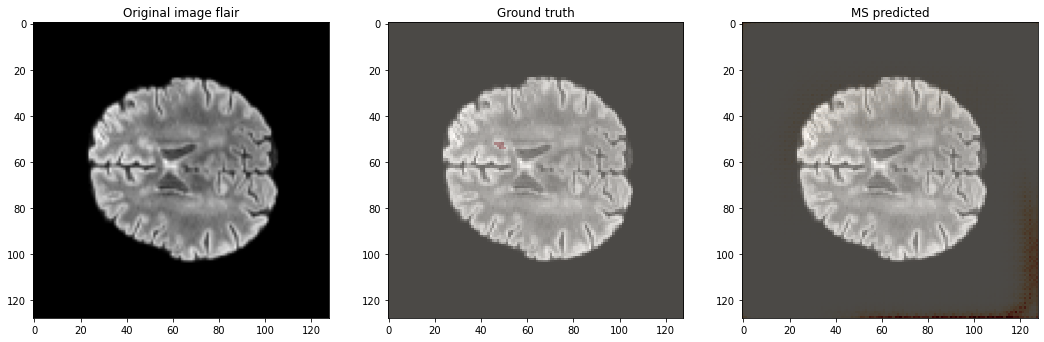

11/11 [==============================] - 28s 3s/step


<Figure size 1296x2160 with 0 Axes>

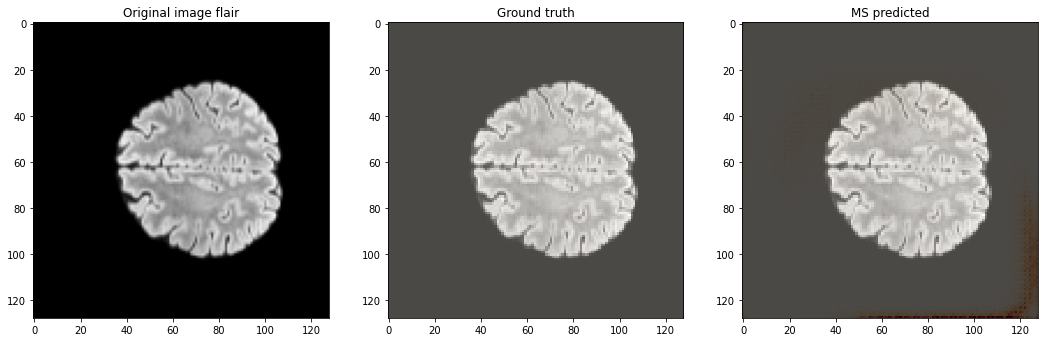

In [66]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`

VOLUME_START_AT=60
VOLUME_SLICES=350

 
#VOLUME_SLICES = 180 
#VOLUME_START_AT =300


def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'MSSEG2016_TrainingData_Patient{case}_FLAIR_preprocessed.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'MSSEG2016_TrainingData_Patient{case}_DP_preprocessed.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model_dualvnet.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 300):
    path = f"D:/Projects/39111/Second_update/MSSEG2016_TrainingData/MSSEG2016_TrainingData_Patient{case}"
    gt = nib.load(os.path.join(path, f'MSSEG2016_TrainingData_Patient{case}_Consensus.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'MSSEG2016_TrainingData_Patient{case}_FLAIR_preprocessed.nii')).get_fdata()
    p = predictByPath(path,case)
    
    #NOT_MS = p[:,:,:,0]
    MS = p[:,:,:,1]
        
    #edema= p[:,:,:,1]
    
    #enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 30))
    f, axarr = plt.subplots(1,3, figsize = (18, 30)) 

    for i in range(3): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    axarr[1].imshow(curr_gt, cmap="OrRd", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    
    #axarr[2].imshow(p[start_slice,:,:,0:1], cmap="OrRd", interpolation='none', alpha=0.3)
    #axarr[2].title.set_text('all classes')
    
    axarr[2].imshow(MS[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[2].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    
    #axarr[4].imshow(MS[start_slice,:,:], cmap="Reds", interpolation='none', alpha=0.3)
    #axarr[4].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    #axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    #axarr[4].title.set_text(f'{SEGMENT_CLASSES[0]} predicted')
    #axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    #axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    
    plt.show()
    
    
showPredictsById(case=val_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=val_ids[4][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=val_ids[3][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=val_ids[5][-3:])

# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()
